<img src="img/array.png" width="25%" align="right">

Arrays
======

Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

**Related Documentation**

* http://dask.readthedocs.io/en/latest/array.html
* http://dask.readthedocs.io/en/latest/array-api.html

### Exercise:  Meteorological data

There is 2GB of somewhat artifical weather data in HDF5 files in `data/weather-big/*.hdf5`.  We'll use the `h5py` library to interact with this data and `dask.array` to compute on it.

Our goal is to visualize the average temperature on the surface of the Earth for this month.  This will require a mean over all of this data.  We'll do this in the following steps

1.  Create `h5py.Dataset` objects for each of the days of data on disk (`dsets`)
2.  Wrap these with `da.from_array` calls 
3.  Stack these datasets along time with a call to `da.stack`
4.  Compute the mean along the newly stacked time axis with the `.mean()` method
5.  Visualize the result with `matplotlib.pyplot.imshow`

In [1]:
from prep import create_weather  # Prep data if it doesn't exist

In [2]:
import os 
os.chdir('/local')

In [3]:
create_weather()

In [4]:
import h5py
from glob import glob
import os

filenames = sorted(glob('weather-big/*.hdf5'))
dsets = [h5py.File(filename)['/t2m'] for filename in filenames]
dsets[0]

<HDF5 dataset "t2m": shape (5760, 11520), type "|u1">

In [5]:
dsets[0][:5, :5]  # Slicing into h5py.Dataset object gives a numpy array

array([[81, 81, 81, 81, 81],
       [81, 81, 81, 81, 81],
       [81, 81, 81, 81, 81],
       [81, 81, 81, 81, 81],
       [81, 81, 81, 81, 81]], dtype=uint8)

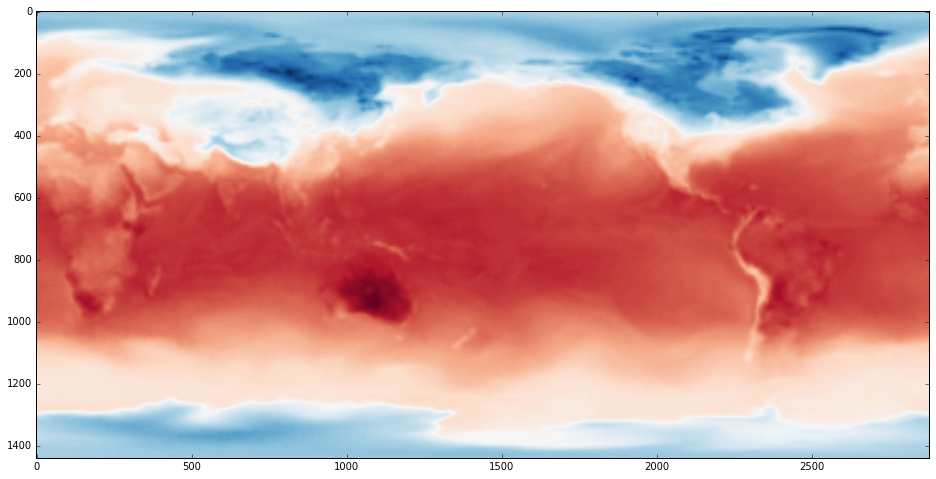

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.imshow(dsets[0][::4, ::4], cmap='RdBu_r')

#### Integrate with `dask.array`

Make a list of `dask.array` objects out of your list of `h5py.Dataset` objects using the `da.from_array` function with a chunk size of `(500, 500)`.

In [6]:
dsets

[<HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type "|u1">,
 <HDF5 dataset "t2m": shape (5760, 11520), type 

In [7]:
import dask.array as da

In [8]:
a = [da.from_array(ds, chunks=(500, 500)) for ds in dsets]

#### Stack this list of `dask.array` objects into a single `dask.array` object with `da.stack`

Stack these along the first axis so that the shape of the resulting array is `(31, 5760, 11520)`.

In [9]:
aa = da.stack(a)

In [10]:
aa

dask.array<stack-6..., shape=(31, 5760, 11520), dtype=uint8, chunksize=(1, 500, 500)>

In [11]:
aa.nbytes / 1024**3

1.915740966796875

#### Plot the mean of this array along the time (`0th`) axis

In [ ]:
%%time
mean_time = aa.mean(axis=0).compute()

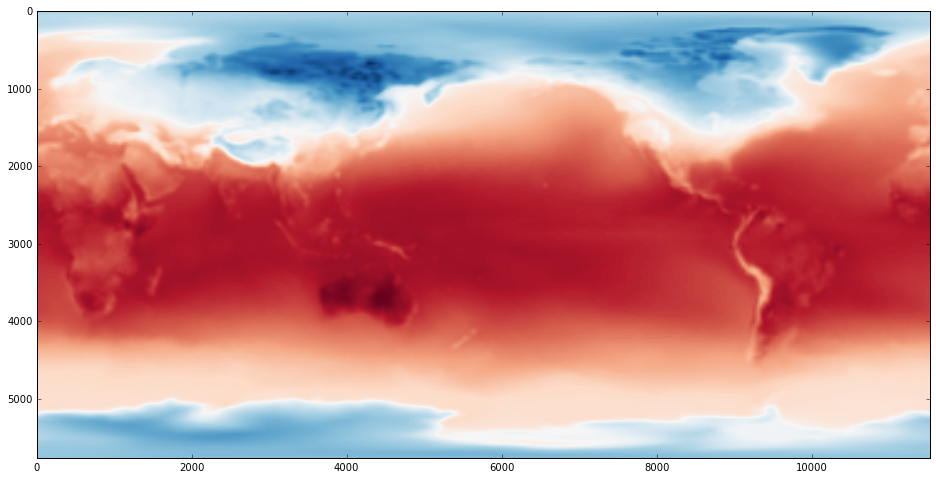

In [48]:
fig = plt.figure(figsize=(16, 8))
plt.imshow(mean_time, cmap='RdBu_r')

#### Plot the difference of the first day from the mean

In [51]:
diff0 = (aa[0] - mean_time)

In [52]:
%%time
diff0 = diff0.compute()

CPU times: user 840 ms, sys: 260 ms, total: 1.1 s
Wall time: 863 ms


In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.imshow(diff0, cmap='RdBu_r')

Limitations
-----------

Dask.array does not implement the entire numpy interface.  Users expecting this
will be disappointed.  Notably dask.array has the following failings:

1.  Dask does not implement all of ``np.linalg``.  This has been done by a
    number of excellent BLAS/LAPACK implementations and is the focus of
    numerous ongoing academic research projects.
2.  Dask.array does not support any operation where the resulting shape
    depends on the values of the array.  In order to form the dask graph we
    must be able to infer the shape of the array before actually executing the
    operation.  This precludes operations like indexing one dask array with
    another or operations like ``np.where``.
3.  Dask.array does not attempt operations like ``sort`` which are notoriously
    difficult to do in parallel and are of somewhat diminished value on very
    large data (you rarely actually need a full sort).
    Often we include parallel-friendly alternatives like ``topk``.
4.  Dask development is driven by immediate need, and so many lesser used
    functions, like ``np.full_like`` have not been implemented purely out of
    laziness.  These would make excellent community contributions.